In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from causal_meta.utils.data_utils import RandomSplineSCM
import causal_meta.utils.train_utils as tu

from encoder import Rotor
from causal_meta.modules.mdn import MDN, mdn_nll
from causal_meta.modules.gmm import GaussianMixture

In [4]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

## Utilities

In [5]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

def normal_like(X): 
    mean = X.mean()
    std = X.std()
    return normal(mean, std, X.size(0))

## Mixture Density

In [6]:
def mdn(opt): 
    return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

## Reversible Encoder

In [7]:
def xcodergen(opt): 
    # Make rotor
    return Rotor(opt.XCODER_INIT)

## Ground Truth Generator

We use a posterior of the form: 

$$
P(Y | X) = \sum_i \pi_i(X) \mathcal{N}(\mu_i(X), \sigma_i(X))
$$

which is a mixture of 10 gaussians. 

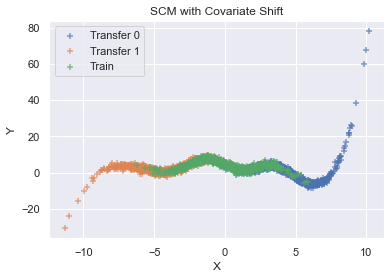

In [8]:
# Test
rand_scm = RandomSplineSCM(False, True, 8, 8, 3, range_scale=1.)

plt.figure()
plt.title("SCM with Covariate Shift")
rand_scm.plot(X=normal(4, 2, 1000), show=False, label='Transfer 0', alpha=0.7)
rand_scm.plot(X=normal(-4, 2, 1000), show=False, label='Transfer 1', alpha=0.7)
rand_scm.plot(X=normal(0, 2, 1000), show=False, label='Train', alpha=0.7)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Visualization

In [9]:
def plot_key(frames, key, show=True, label=None, name=None): 
    its, vals = zip(*[(frame.iter_num, getattr(frame, key)) for frame in frames])
    if show:
        plt.figure()
    plt.plot(its, vals, label=label)
    if show:
        plt.xlabel("Iterations")
        plt.ylabel(name if name is not None else key.title())
        plt.show()

## Training

In [10]:
def gradnan_filter(model): 
    nan_found = False
    for p in model.parameters(): 
        nan_mask = torch.isnan(p.grad.data)
        nan_found = bool(nan_mask.any().item())
        p.grad.data[nan_mask] = 0.
    return nan_found

In [11]:
def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp, n_iter=opt.EM_ITERS)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

In [12]:
def encoder_train_shared_regret(opt, model_x2y, model_y2x, scm, encoder, decoder, alpha): 
    if opt.CUDA: 
        model_x2y = model_x2y.cuda()
        model_y2x = model_y2x.cuda()
        encoder = encoder.cuda()
        decoder = decoder.cuda()
     
    frames = []
    for meta_iter in tqdm.trange(opt.NUM_META_ITER): 
        # Preheat the models
        _ = tu.train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, 'X2Y', 
                         mdn_nll, decoder, encoder, quiet=True)
        _ = tu.train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, 'Y2X', 
                         mdn_nll, decoder, encoder, quiet=True)
        # Sample from SCM
        X = opt.TRANS_DISTRY()
        Y = scm(X)
        if opt.CUDA: 
            X, Y = X.cuda(), Y.cuda()
        
        # Decode 
        with torch.no_grad(): 
            X, Y = decoder(X, Y)
        
        # Encode
        X, Y = encoder(X, Y)
        
        #GMM module is called. But why?
        
        with torch.no_grad():
            
            if opt.USE_BASELINE:
                baseline_y = marginal_nll(opt, Y, mdn_nll)
                baseline_x = marginal_nll(opt, X, mdn_nll)
            else:
                baseline_y = 0.
                baseline_x = 0.
                
        # Save state dicts
        state_x2y = deepcopy(model_x2y.state_dict())
        state_y2x = deepcopy(model_y2x.state_dict())
        
        # Inner loop for optimisation
        optim_x2y = torch.optim.Adam(model_x2y.parameters(), lr=opt.FINETUNE_LR)
        optim_y2x = torch.optim.Adam(model_y2x.parameters(), lr=opt.FINETUNE_LR)
        regrets_x2y = []
        regrets_y2x = []
        is_nan = False
        
        # Evaluate regret discrepancy 
        for t in range(opt.FINETUNE_NUM_ITER):
            loss_x2y = mdn_nll(model_x2y(X), Y)
            loss_y2x = mdn_nll(model_y2x(Y), X)
            if torch.isnan(loss_x2y).item() or torch.isnan(loss_y2x).item(): 
                is_nan = True
                break
            optim_x2y.zero_grad()
            optim_y2x.zero_grad()
            loss_x2y.backward(retain_graph=True) 
            loss_y2x.backward(retain_graph=True)
            
            # Filter out NaNs that might have sneaked in
            nan_in_x2y = gradnan_filter(model_x2y)
            nan_in_y2x = gradnan_filter(model_y2x)
            if nan_in_x2y or nan_in_y2x: 
                is_nan = True
                break
            
            optim_x2y.step()
            optim_y2x.step()
            # Store for encoder Adding the baselines here
            regrets_x2y.append(loss_x2y + baseline_x)
            regrets_y2x.append(loss_y2x + baseline_y)
        
        if not is_nan:
            # Evaluate total regret
            regret_x2y = torch.stack(regrets_x2y).mean()
            regret_y2x = torch.stack(regrets_y2x).mean()
            # Evaluate losses
            loss = torch.logsumexp(
                torch.stack([F.logsigmoid(alpha) + regret_x2y,
                             F.logsigmoid(-alpha) + regret_y2x]), 
                0)
            # Optimize
            encoder_optim.zero_grad()
            alpha_optim.zero_grad()
            loss.backward()
            
            # Make sure no nans
            if torch.isnan(encoder.theta.grad.data).any(): 
                encoder.theta.grad.data.zero_()
            if torch.isnan(alpha.grad.data).any(): 
                alpha.grad.data.zero_()
            encoder_optim.step()
            alpha_optim.step()
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=regret_x2y.item(), 
                                    regret_y2x=regret_y2x.item(),
                                    loss=loss.item(),
                                    alpha=alpha.item(), 
                                    theta=encoder.theta.item()))
        else:
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add dummy info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=float('nan'), 
                                    regret_y2x=float('nan'),
                                    loss=float('nan'),
                                    alpha=float('nan'), 
                                    theta=float('nan')))
            
    return frames

In [13]:
def plot_theta(frames, gt_theta, save=False): 
    its, vals = zip(*[(frame.iter_num, frame.theta / (np.pi / 2)) for frame in frames])
    gt_theta = -gt_theta.item() / (np.pi / 2)
    plt.figure()
    # plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$', c='black')
    plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$')
    plt.plot(its, [gt_theta] * len(its), linestyle='--', label=r'Solution 1 $\left(+\frac{\pi}{4}\right)$')
    plt.plot(its, [gt_theta - 1] * len(its), linestyle='--', label=r'Solution 2 $\left(-\frac{\pi}{4}\right)$')
    plt.xlabel("Iterations")
    plt.ylabel("Encoder Angle [π/2 rad]")
    plt.legend()
    if save:
        plt.savefig('fixed-encoder-evo.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [14]:
def probe_xcoders(encoder, decoder):
    # Test encoder and decoder
    with torch.no_grad():
        _X = torch.tensor([[1.]])
        _Y = torch.tensor([[0.]])
        if opt.CUDA:
            _X, _Y = _X.to(encoder.theta.device), _Y.to(encoder.theta.device)
        _X_d, _Y_d = decoder(_X, _Y)
        _X_de, _Y_de = encoder(_X_d, _Y_d)
    print(f"Initial (A, B) = {_X.item()}, {_Y.item()}")
    print(f"Decoded (X, Y) = {_X_d.item()}, {_Y_d.item()}")
    print(f"Encoded (U, V) = {_X_de.item()}, {_Y_de.item()}")

# Experiments with Unfixed Encoders

In [15]:
opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10

# Training
opt.LR = 0.01
opt.NUM_ITER = 20
opt.NUM_META_ITER = 1000
opt.ENCODER_LR = 0.01
opt.ALPHA_LR = 0.001
opt.CUDA = False
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 500

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES)

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

## Make Xcoders

Make a ground-truth decoder with $\theta_0$. 

In [16]:
gt_decoder = Rotor(opt.DECODER_DEFAULT)

The real encoder should have $\theta = -\theta_0$. 

In [17]:
encoder = Rotor(0. * np.pi/2)

In [18]:
probe_xcoders(encoder, gt_decoder)

Initial (A, B) = 1.0, 0.0
Decoded (X, Y) = 0.7071067690849304, 0.7071067690849304
Encoded (U, V) = 0.7071067690849304, 0.7071067690849304


## Make Alpha and Models

In [19]:
alpha = tu.make_alpha(opt)

In [20]:
model_x2y = mdn(opt)
model_y2x = mdn(opt)

## Train Encoder

If it doesn't work with the seed of your choice, try tuning the (hyper)parameters of ```opt.TRANS_DISTRY```. Since the SCM is generated randomly, it's not possible to know the correct hyper-parameters in advance (unless the seed is fixed). $\sigma \in (1, 2)$ should work fine, but if the range from which the means are sampled is too large, you can have numerical instabilities. If it's too small, the gradient signal to the encoder can be weak. 

In [21]:
frames = encoder_train_shared_regret(opt, model_x2y, model_y2x, rand_scm, encoder, gt_decoder, alpha)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|                                          | 1/1000 [00:01<19:19,  1.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|                                          | 2/1000 [00:01<15:46,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|▏                                         | 3/1000 [00:03<16:43,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|▏                                         | 4/1000 [00:03<15:52,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|▏                                         | 5/1000 [00:04<15:41,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▎                                         | 6/1000 [00:05<15:28,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▎                                         | 7/1000 [00:06<16:27,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▎                                         | 8/1000 [00:07<15:25,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▍                                         | 9/1000 [00:08<14:22,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▍                                        | 10/1000 [00:09<13:41,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▍                                        | 11/1000 [00:10<14:38,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▍                                        | 12/1000 [00:11<14:44,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▌                                        | 13/1000 [00:12<16:33,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|▌                                        | 14/1000 [00:13<15:59,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▌                                        | 15/1000 [00:14<15:38,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▋                                        | 16/1000 [00:14<14:59,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▋                                        | 17/1000 [00:16<15:44,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▋                                        | 18/1000 [00:16<14:23,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▊                                        | 19/1000 [00:17<14:13,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▊                                        | 20/1000 [00:18<13:55,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▊                                        | 21/1000 [00:19<14:52,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▉                                        | 22/1000 [00:20<15:56,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▉                                        | 23/1000 [00:21<15:01,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|▉                                        | 24/1000 [00:22<15:13,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  2%|█                                        | 25/1000 [00:23<15:50,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█                                        | 26/1000 [00:24<15:41,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█                                        | 27/1000 [00:25<15:37,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▏                                       | 28/1000 [00:26<14:56,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▏                                       | 29/1000 [00:27<15:38,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▏                                       | 30/1000 [00:28<15:05,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▎                                       | 31/1000 [00:28<13:59,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▎                                       | 32/1000 [00:29<14:59,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▎                                       | 33/1000 [00:30<15:57,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|█▍                                       | 34/1000 [00:31<15:28,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▍                                       | 35/1000 [00:32<15:42,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▍                                       | 36/1000 [00:33<16:02,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▌                                       | 37/1000 [00:34<14:43,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▌                                       | 38/1000 [00:35<14:19,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▌                                       | 39/1000 [00:36<15:02,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▋                                       | 40/1000 [00:37<15:40,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▋                                       | 41/1000 [00:38<14:04,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▋                                       | 42/1000 [00:38<13:16,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▊                                       | 43/1000 [00:39<13:37,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▊                                       | 44/1000 [00:40<12:41,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|█▊                                       | 45/1000 [00:41<13:28,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|█▉                                       | 46/1000 [00:42<13:51,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|█▉                                       | 47/1000 [00:43<14:17,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|█▉                                       | 48/1000 [00:44<14:24,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|██                                       | 49/1000 [00:45<14:57,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|██                                       | 50/1000 [00:46<14:56,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|██                                       | 51/1000 [00:47<15:01,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|██▏                                      | 52/1000 [00:48<14:54,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|██▏                                      | 53/1000 [00:49<15:10,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|██▏                                      | 54/1000 [00:50<15:03,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▎                                      | 55/1000 [00:51<15:05,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▎                                      | 56/1000 [00:51<14:14,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▎                                      | 57/1000 [00:52<13:57,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▍                                      | 58/1000 [00:53<14:14,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▍                                      | 59/1000 [00:54<15:08,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▍                                      | 60/1000 [00:55<15:12,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▌                                      | 61/1000 [00:56<15:24,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▌                                      | 62/1000 [00:57<13:53,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▌                                      | 63/1000 [00:58<13:47,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▌                                      | 64/1000 [00:59<13:09,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  6%|██▋                                      | 65/1000 [00:59<13:30,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▋                                      | 66/1000 [01:00<13:36,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▋                                      | 67/1000 [01:01<13:18,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▊                                      | 68/1000 [01:02<13:20,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▊                                      | 69/1000 [01:03<14:08,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▊                                      | 70/1000 [01:04<14:12,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▉                                      | 71/1000 [01:05<14:37,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▉                                      | 72/1000 [01:06<14:15,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|██▉                                      | 73/1000 [01:07<15:22,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|███                                      | 74/1000 [01:08<15:02,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███                                      | 75/1000 [01:09<13:46,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███                                      | 76/1000 [01:10<13:35,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▏                                     | 77/1000 [01:11<14:12,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▏                                     | 78/1000 [01:12<14:14,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▏                                     | 79/1000 [01:12<14:13,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▎                                     | 80/1000 [01:13<14:08,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▎                                     | 81/1000 [01:14<13:59,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▎                                     | 82/1000 [01:15<13:30,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▍                                     | 83/1000 [01:16<14:11,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▍                                     | 84/1000 [01:17<14:38,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  8%|███▍                                     | 85/1000 [01:18<13:28,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▌                                     | 86/1000 [01:19<13:53,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▌                                     | 87/1000 [01:20<14:23,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▌                                     | 88/1000 [01:20<13:01,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▋                                     | 89/1000 [01:21<13:32,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▋                                     | 90/1000 [01:22<13:06,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▋                                     | 91/1000 [01:23<13:13,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▊                                     | 92/1000 [01:24<13:10,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▊                                     | 93/1000 [01:25<12:45,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  9%|███▊                                     | 94/1000 [01:26<13:43,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|███▉                                     | 95/1000 [01:27<13:39,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|███▉                                     | 96/1000 [01:28<12:55,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|███▉                                     | 97/1000 [01:28<13:24,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████                                     | 98/1000 [01:29<13:35,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████                                     | 99/1000 [01:30<13:05,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████                                    | 100/1000 [01:31<12:06,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████                                    | 101/1000 [01:32<12:20,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████                                    | 102/1000 [01:33<13:35,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████                                    | 103/1000 [01:34<13:47,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████▏                                   | 104/1000 [01:35<13:53,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 10%|████▏                                   | 105/1000 [01:35<12:49,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▏                                   | 106/1000 [01:36<12:17,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▎                                   | 107/1000 [01:37<12:17,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▎                                   | 108/1000 [01:38<13:20,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▎                                   | 109/1000 [01:39<13:19,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▍                                   | 110/1000 [01:40<13:59,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▍                                   | 111/1000 [01:41<13:33,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▍                                   | 112/1000 [01:42<14:13,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▌                                   | 113/1000 [01:43<14:52,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|████▌                                   | 114/1000 [01:44<14:30,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▌                                   | 115/1000 [01:45<14:20,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▋                                   | 116/1000 [01:46<13:58,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▋                                   | 117/1000 [01:47<14:08,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▋                                   | 118/1000 [01:47<12:57,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▊                                   | 119/1000 [01:49<13:52,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▊                                   | 120/1000 [01:49<13:29,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▊                                   | 121/1000 [01:50<14:00,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▉                                   | 122/1000 [01:51<13:13,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▉                                   | 123/1000 [01:52<12:23,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|████▉                                   | 124/1000 [01:53<12:10,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 12%|█████                                   | 125/1000 [01:54<12:16,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████                                   | 126/1000 [01:55<12:19,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████                                   | 127/1000 [01:55<12:01,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████                                   | 128/1000 [01:56<13:04,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████▏                                  | 129/1000 [01:57<12:52,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████▏                                  | 130/1000 [01:58<13:13,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████▏                                  | 131/1000 [01:59<12:18,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████▎                                  | 132/1000 [02:00<13:02,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████▎                                  | 133/1000 [02:01<12:19,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█████▎                                  | 134/1000 [02:02<12:32,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▍                                  | 135/1000 [02:02<12:13,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▍                                  | 136/1000 [02:03<11:46,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▍                                  | 137/1000 [02:04<11:54,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▌                                  | 138/1000 [02:05<12:39,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▌                                  | 139/1000 [02:06<13:17,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▌                                  | 140/1000 [02:07<13:26,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▋                                  | 141/1000 [02:08<13:35,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▋                                  | 142/1000 [02:09<13:20,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▋                                  | 143/1000 [02:10<13:29,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▊                                  | 144/1000 [02:11<13:48,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█████▊                                  | 145/1000 [02:12<14:07,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█████▊                                  | 146/1000 [02:13<13:11,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█████▉                                  | 147/1000 [02:14<13:15,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█████▉                                  | 148/1000 [02:14<13:02,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|█████▉                                  | 149/1000 [02:16<13:41,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|██████                                  | 150/1000 [02:16<11:48,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|██████                                  | 151/1000 [02:17<11:21,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|██████                                  | 152/1000 [02:18<12:12,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|██████                                  | 153/1000 [02:18<10:45,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 15%|██████▏                                 | 154/1000 [02:19<12:03,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▏                                 | 155/1000 [02:20<11:39,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▏                                 | 156/1000 [02:21<12:18,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▎                                 | 157/1000 [02:22<12:17,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▎                                 | 158/1000 [02:23<12:51,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▎                                 | 159/1000 [02:24<13:20,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▍                                 | 160/1000 [02:25<13:46,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▍                                 | 161/1000 [02:26<14:06,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▍                                 | 162/1000 [02:27<14:12,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▌                                 | 163/1000 [02:28<14:17,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▌                                 | 164/1000 [02:29<12:46,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 16%|██████▌                                 | 165/1000 [02:30<12:22,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▋                                 | 166/1000 [02:31<13:24,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▋                                 | 167/1000 [02:32<12:55,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▋                                 | 168/1000 [02:32<11:40,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▊                                 | 169/1000 [02:33<11:16,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▊                                 | 170/1000 [02:34<12:11,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▊                                 | 171/1000 [02:35<12:37,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▉                                 | 172/1000 [02:36<13:11,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▉                                 | 173/1000 [02:37<13:31,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|██████▉                                 | 174/1000 [02:38<11:47,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████                                 | 175/1000 [02:39<12:44,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████                                 | 176/1000 [02:40<12:45,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████                                 | 177/1000 [02:41<11:49,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████                                 | 178/1000 [02:42<12:27,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▏                                | 179/1000 [02:42<11:11,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▏                                | 180/1000 [02:43<11:15,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▏                                | 181/1000 [02:44<11:35,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▎                                | 182/1000 [02:45<11:42,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▎                                | 183/1000 [02:46<12:11,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▎                                | 184/1000 [02:47<12:54,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 18%|███████▍                                | 185/1000 [02:48<12:30,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▍                                | 186/1000 [02:49<12:32,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▍                                | 187/1000 [02:50<13:53,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▌                                | 188/1000 [02:51<15:24,  1.14s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▌                                | 189/1000 [02:52<14:18,  1.06s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▌                                | 190/1000 [02:53<14:56,  1.11s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▋                                | 191/1000 [02:54<14:43,  1.09s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▋                                | 192/1000 [02:55<13:24,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▋                                | 193/1000 [02:56<12:51,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 19%|███████▊                                | 194/1000 [02:57<12:07,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|███████▊                                | 195/1000 [02:58<11:29,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|███████▊                                | 196/1000 [02:58<10:32,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|███████▉                                | 197/1000 [02:59<11:20,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|███████▉                                | 198/1000 [03:00<11:24,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|███████▉                                | 199/1000 [03:01<12:09,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████                                | 200/1000 [03:02<13:04,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████                                | 201/1000 [03:03<12:51,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████                                | 202/1000 [03:04<13:18,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████                                | 203/1000 [03:05<12:35,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████▏                               | 204/1000 [03:06<12:27,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 20%|████████▏                               | 205/1000 [03:07<12:52,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▏                               | 206/1000 [03:08<13:32,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▎                               | 207/1000 [03:09<13:48,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▎                               | 208/1000 [03:10<13:54,  1.05s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▎                               | 209/1000 [03:11<13:01,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▍                               | 210/1000 [03:12<12:34,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▍                               | 211/1000 [03:13<11:47,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▍                               | 212/1000 [03:14<11:43,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▌                               | 213/1000 [03:15<12:02,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|████████▌                               | 214/1000 [03:16<13:11,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▌                               | 215/1000 [03:17<14:34,  1.11s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▋                               | 216/1000 [03:18<13:36,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▋                               | 217/1000 [03:19<13:27,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▋                               | 218/1000 [03:20<12:43,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▊                               | 219/1000 [03:21<12:20,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▊                               | 220/1000 [03:22<12:29,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▊                               | 221/1000 [03:23<13:02,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▉                               | 222/1000 [03:24<11:56,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▉                               | 223/1000 [03:25<12:24,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|████████▉                               | 224/1000 [03:26<11:48,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 22%|█████████                               | 225/1000 [03:26<10:53,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████                               | 226/1000 [03:27<10:42,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████                               | 227/1000 [03:28<11:37,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████                               | 228/1000 [03:29<11:50,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████▏                              | 229/1000 [03:30<12:18,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████▏                              | 230/1000 [03:31<12:17,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████▏                              | 231/1000 [03:32<12:16,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████▎                              | 232/1000 [03:33<12:32,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████▎                              | 233/1000 [03:34<12:38,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 23%|█████████▎                              | 234/1000 [03:35<12:17,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▍                              | 235/1000 [03:36<11:43,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▍                              | 236/1000 [03:37<11:56,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▍                              | 237/1000 [03:38<11:55,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▌                              | 238/1000 [03:39<12:11,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▌                              | 239/1000 [03:40<11:19,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▌                              | 240/1000 [03:40<11:12,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▋                              | 241/1000 [03:41<11:40,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▋                              | 242/1000 [03:42<11:35,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▋                              | 243/1000 [03:43<11:23,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▊                              | 244/1000 [03:44<11:57,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|█████████▊                              | 245/1000 [03:45<11:54,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|█████████▊                              | 246/1000 [03:46<10:54,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|█████████▉                              | 247/1000 [03:47<11:09,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|█████████▉                              | 248/1000 [03:48<11:38,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|█████████▉                              | 249/1000 [03:49<11:11,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██████████                              | 250/1000 [03:50<11:49,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██████████                              | 251/1000 [03:51<12:36,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██████████                              | 252/1000 [03:52<13:32,  1.09s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██████████                              | 253/1000 [03:53<12:41,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██████████▏                             | 254/1000 [03:54<12:01,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▏                             | 255/1000 [03:55<12:18,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▏                             | 256/1000 [03:56<11:58,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▎                             | 257/1000 [03:57<12:16,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▎                             | 258/1000 [03:58<11:54,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▎                             | 259/1000 [03:59<11:20,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▍                             | 260/1000 [04:00<11:58,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▍                             | 261/1000 [04:01<11:38,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▍                             | 262/1000 [04:01<11:37,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▌                             | 263/1000 [04:03<12:01,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▌                             | 264/1000 [04:03<11:51,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 26%|██████████▌                             | 265/1000 [04:04<11:39,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▋                             | 266/1000 [04:05<12:02,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▋                             | 267/1000 [04:06<11:23,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▋                             | 268/1000 [04:07<10:59,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▊                             | 269/1000 [04:08<11:26,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▊                             | 270/1000 [04:09<12:42,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▊                             | 271/1000 [04:10<11:58,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▉                             | 272/1000 [04:11<11:45,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▉                             | 273/1000 [04:12<12:01,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██████████▉                             | 274/1000 [04:13<12:14,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████                             | 275/1000 [04:14<11:27,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████                             | 276/1000 [04:15<11:12,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████                             | 277/1000 [04:16<11:44,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████                             | 278/1000 [04:17<11:14,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▏                            | 279/1000 [04:18<11:44,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▏                            | 280/1000 [04:19<11:33,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▏                            | 281/1000 [04:20<11:59,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▎                            | 282/1000 [04:21<11:20,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▎                            | 283/1000 [04:22<11:15,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▎                            | 284/1000 [04:22<09:43,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 28%|███████████▍                            | 285/1000 [04:23<09:45,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▍                            | 286/1000 [04:24<10:31,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▍                            | 287/1000 [04:25<10:41,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▌                            | 288/1000 [04:26<10:24,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▌                            | 289/1000 [04:27<10:45,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▌                            | 290/1000 [04:28<11:14,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▋                            | 291/1000 [04:29<11:45,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▋                            | 292/1000 [04:30<12:04,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▋                            | 293/1000 [04:31<11:49,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 29%|███████████▊                            | 294/1000 [04:32<10:45,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███████████▊                            | 295/1000 [04:33<10:47,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███████████▊                            | 296/1000 [04:34<10:42,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███████████▉                            | 297/1000 [04:35<10:43,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███████████▉                            | 298/1000 [04:35<09:31,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|███████████▉                            | 299/1000 [04:36<09:28,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|████████████                            | 300/1000 [04:37<09:49,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|████████████                            | 301/1000 [04:38<10:41,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|████████████                            | 302/1000 [04:39<09:32,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|████████████                            | 303/1000 [04:40<10:16,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|████████████▏                           | 304/1000 [04:40<10:30,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 30%|████████████▏                           | 305/1000 [04:41<09:56,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▏                           | 306/1000 [04:42<10:34,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▎                           | 307/1000 [04:43<10:29,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▎                           | 308/1000 [04:44<10:20,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▎                           | 309/1000 [04:45<10:50,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▍                           | 310/1000 [04:46<09:59,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▍                           | 311/1000 [04:47<09:54,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▍                           | 312/1000 [04:48<11:12,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▌                           | 313/1000 [04:49<10:17,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|████████████▌                           | 314/1000 [04:50<11:01,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▌                           | 315/1000 [04:51<10:58,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▋                           | 316/1000 [04:52<10:40,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▋                           | 317/1000 [04:52<10:26,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▋                           | 318/1000 [04:53<09:49,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▊                           | 319/1000 [04:54<09:39,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▊                           | 320/1000 [04:55<09:46,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▊                           | 321/1000 [04:56<10:25,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▉                           | 322/1000 [04:57<10:12,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▉                           | 323/1000 [04:58<10:58,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|████████████▉                           | 324/1000 [04:59<10:15,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 32%|█████████████                           | 325/1000 [05:00<10:38,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████                           | 326/1000 [05:01<10:50,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████                           | 327/1000 [05:02<10:35,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████                           | 328/1000 [05:03<10:31,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████▏                          | 329/1000 [05:03<09:48,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████▏                          | 330/1000 [05:04<09:57,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████▏                          | 331/1000 [05:05<10:20,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████▎                          | 332/1000 [05:06<10:43,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████▎                          | 333/1000 [05:07<09:27,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 33%|█████████████▎                          | 334/1000 [05:08<09:21,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▍                          | 335/1000 [05:09<09:55,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▍                          | 336/1000 [05:10<10:17,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▍                          | 337/1000 [05:10<09:13,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▌                          | 338/1000 [05:11<09:49,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▌                          | 339/1000 [05:12<10:16,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▌                          | 340/1000 [05:13<10:00,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▋                          | 341/1000 [05:14<09:28,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▋                          | 342/1000 [05:15<08:31,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▋                          | 343/1000 [05:15<08:34,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▊                          | 344/1000 [05:16<09:23,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|█████████████▊                          | 345/1000 [05:17<08:29,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|█████████████▊                          | 346/1000 [05:18<08:17,  1.32it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|█████████████▉                          | 347/1000 [05:19<08:58,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|█████████████▉                          | 348/1000 [05:19<08:16,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|█████████████▉                          | 349/1000 [05:20<08:12,  1.32it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|██████████████                          | 350/1000 [05:21<08:59,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|██████████████                          | 351/1000 [05:22<09:33,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|██████████████                          | 352/1000 [05:23<10:02,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|██████████████                          | 353/1000 [05:24<10:02,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 35%|██████████████▏                         | 354/1000 [05:25<10:04,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▏                         | 355/1000 [05:26<10:32,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▏                         | 356/1000 [05:27<10:23,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▎                         | 357/1000 [05:28<10:30,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▎                         | 358/1000 [05:29<09:01,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▎                         | 359/1000 [05:29<09:04,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▍                         | 360/1000 [05:30<09:00,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▍                         | 361/1000 [05:31<08:56,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▍                         | 362/1000 [05:32<10:03,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▌                         | 363/1000 [05:33<10:13,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▌                         | 364/1000 [05:34<09:56,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 36%|██████████████▌                         | 365/1000 [05:35<10:45,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▋                         | 366/1000 [05:37<11:25,  1.08s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▋                         | 367/1000 [05:37<10:27,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▋                         | 368/1000 [05:38<10:36,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▊                         | 369/1000 [05:39<09:15,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▊                         | 370/1000 [05:40<09:54,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▊                         | 371/1000 [05:41<10:06,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▉                         | 372/1000 [05:42<08:58,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▉                         | 373/1000 [05:43<09:35,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|██████████████▉                         | 374/1000 [05:43<08:55,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████                         | 375/1000 [05:44<08:38,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████                         | 376/1000 [05:45<09:10,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████                         | 377/1000 [05:46<09:19,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████                         | 378/1000 [05:47<09:43,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▏                        | 379/1000 [05:48<09:56,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▏                        | 380/1000 [05:49<09:48,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▏                        | 381/1000 [05:50<09:50,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▎                        | 382/1000 [05:51<09:09,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▎                        | 383/1000 [05:52<08:50,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▎                        | 384/1000 [05:52<07:47,  1.32it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 38%|███████████████▍                        | 385/1000 [05:53<08:13,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▍                        | 386/1000 [05:54<07:57,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▍                        | 387/1000 [05:55<08:21,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▌                        | 388/1000 [05:56<09:00,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▌                        | 389/1000 [05:57<08:53,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▌                        | 390/1000 [05:57<08:29,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▋                        | 391/1000 [05:58<08:42,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▋                        | 392/1000 [05:59<08:52,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▋                        | 393/1000 [06:00<09:20,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 39%|███████████████▊                        | 394/1000 [06:01<08:40,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|███████████████▊                        | 395/1000 [06:02<08:01,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|███████████████▊                        | 396/1000 [06:02<08:03,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|███████████████▉                        | 397/1000 [06:03<07:48,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|███████████████▉                        | 398/1000 [06:04<07:46,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|███████████████▉                        | 399/1000 [06:04<07:24,  1.35it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████████████████                        | 400/1000 [06:05<07:41,  1.30it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████████████████                        | 401/1000 [06:06<07:54,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████████████████                        | 402/1000 [06:07<08:13,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████████████████                        | 403/1000 [06:08<08:39,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████████████████▏                       | 404/1000 [06:09<09:17,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████████████████▏                       | 405/1000 [06:10<09:40,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▏                       | 406/1000 [06:11<10:00,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▎                       | 407/1000 [06:12<09:06,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▎                       | 408/1000 [06:13<09:29,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▎                       | 409/1000 [06:14<09:02,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▍                       | 410/1000 [06:14<08:02,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▍                       | 411/1000 [06:16<08:42,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▍                       | 412/1000 [06:17<09:09,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▌                       | 413/1000 [06:17<08:42,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████████████████▌                       | 414/1000 [06:19<09:32,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▌                       | 415/1000 [06:20<10:32,  1.08s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▋                       | 416/1000 [06:21<11:18,  1.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▋                       | 417/1000 [06:22<11:33,  1.19s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▋                       | 418/1000 [06:24<11:39,  1.20s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▊                       | 419/1000 [06:25<11:15,  1.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▊                       | 420/1000 [06:26<10:00,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▊                       | 421/1000 [06:27<10:03,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▉                       | 422/1000 [06:27<08:46,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▉                       | 423/1000 [06:28<08:36,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|████████████████▉                       | 424/1000 [06:29<09:07,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 42%|█████████████████                       | 425/1000 [06:30<09:19,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████                       | 426/1000 [06:31<09:17,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████                       | 427/1000 [06:32<08:42,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████                       | 428/1000 [06:33<09:00,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████▏                      | 429/1000 [06:34<08:38,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████▏                      | 430/1000 [06:35<08:56,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████▏                      | 431/1000 [06:36<09:19,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████▎                      | 432/1000 [06:37<09:34,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████▎                      | 433/1000 [06:38<10:55,  1.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 43%|█████████████████▎                      | 434/1000 [06:39<09:22,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▍                      | 435/1000 [06:40<10:35,  1.12s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▍                      | 436/1000 [06:41<09:45,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▍                      | 437/1000 [06:42<08:36,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▌                      | 438/1000 [06:43<09:02,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▌                      | 439/1000 [06:44<08:43,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▌                      | 440/1000 [06:45<08:49,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▋                      | 441/1000 [06:46<09:11,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▋                      | 442/1000 [06:47<08:54,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▋                      | 443/1000 [06:48<09:25,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▊                      | 444/1000 [06:49<09:28,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|█████████████████▊                      | 445/1000 [06:50<08:53,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|█████████████████▊                      | 446/1000 [06:51<08:44,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|█████████████████▉                      | 447/1000 [06:52<08:38,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|█████████████████▉                      | 448/1000 [06:52<08:04,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|█████████████████▉                      | 449/1000 [06:53<08:25,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|██████████████████                      | 450/1000 [06:54<08:54,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|██████████████████                      | 451/1000 [06:55<08:39,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|██████████████████                      | 452/1000 [06:56<08:19,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|██████████████████                      | 453/1000 [06:57<08:57,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 45%|██████████████████▏                     | 454/1000 [06:58<08:24,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▏                     | 455/1000 [06:59<08:09,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▏                     | 456/1000 [07:00<07:35,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▎                     | 457/1000 [07:01<08:02,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▎                     | 458/1000 [07:02<08:22,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▎                     | 459/1000 [07:03<09:15,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▍                     | 460/1000 [07:04<09:13,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▍                     | 461/1000 [07:05<09:26,  1.05s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▍                     | 462/1000 [07:06<09:23,  1.05s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▌                     | 463/1000 [07:07<08:53,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▌                     | 464/1000 [07:08<08:23,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 46%|██████████████████▌                     | 465/1000 [07:09<08:33,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▋                     | 466/1000 [07:10<08:38,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▋                     | 467/1000 [07:11<07:57,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▋                     | 468/1000 [07:11<07:23,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▊                     | 469/1000 [07:12<08:00,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▊                     | 470/1000 [07:13<07:53,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▊                     | 471/1000 [07:14<07:48,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▉                     | 472/1000 [07:15<08:03,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▉                     | 473/1000 [07:16<07:50,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|██████████████████▉                     | 474/1000 [07:17<07:25,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████                     | 475/1000 [07:17<07:12,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████                     | 476/1000 [07:18<07:26,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████                     | 477/1000 [07:19<07:47,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████                     | 478/1000 [07:20<07:44,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▏                    | 479/1000 [07:21<07:59,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▏                    | 480/1000 [07:22<08:05,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▏                    | 481/1000 [07:23<08:09,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▎                    | 482/1000 [07:24<07:59,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▎                    | 483/1000 [07:25<07:48,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▎                    | 484/1000 [07:26<07:56,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 48%|███████████████████▍                    | 485/1000 [07:27<08:05,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▍                    | 486/1000 [07:28<07:36,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▍                    | 487/1000 [07:28<07:43,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▌                    | 488/1000 [07:29<07:57,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▌                    | 489/1000 [07:30<07:30,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▌                    | 490/1000 [07:31<07:08,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▋                    | 491/1000 [07:32<07:03,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▋                    | 492/1000 [07:32<06:37,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▋                    | 493/1000 [07:33<06:50,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 49%|███████████████████▊                    | 494/1000 [07:34<06:34,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|███████████████████▊                    | 495/1000 [07:35<06:38,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|███████████████████▊                    | 496/1000 [07:36<06:42,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|███████████████████▉                    | 497/1000 [07:36<06:32,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|███████████████████▉                    | 498/1000 [07:37<06:30,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|███████████████████▉                    | 499/1000 [07:38<07:07,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████████████████████                    | 500/1000 [07:39<07:31,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████████████████████                    | 501/1000 [07:40<07:25,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████████████████████                    | 502/1000 [07:41<07:13,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████████████████████                    | 503/1000 [07:42<07:02,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████████████████████▏                   | 504/1000 [07:43<07:22,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 50%|████████████████████▏                   | 505/1000 [07:44<07:36,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▏                   | 506/1000 [07:44<06:37,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▎                   | 507/1000 [07:45<06:59,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▎                   | 508/1000 [07:46<07:19,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▎                   | 509/1000 [07:47<07:14,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▍                   | 510/1000 [07:48<07:14,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▍                   | 511/1000 [07:49<06:55,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▍                   | 512/1000 [07:50<07:06,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▌                   | 513/1000 [07:50<07:00,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|████████████████████▌                   | 514/1000 [07:51<06:33,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▌                   | 515/1000 [07:52<07:01,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▋                   | 516/1000 [07:53<06:44,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▋                   | 517/1000 [07:54<06:30,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▋                   | 518/1000 [07:54<06:25,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▊                   | 519/1000 [07:55<06:12,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▊                   | 520/1000 [07:56<06:44,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▊                   | 521/1000 [07:57<06:33,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▉                   | 522/1000 [07:58<06:56,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▉                   | 523/1000 [07:59<06:36,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|████████████████████▉                   | 524/1000 [08:00<06:57,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 52%|█████████████████████                   | 525/1000 [08:00<06:53,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████                   | 526/1000 [08:01<06:48,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████                   | 527/1000 [08:02<07:02,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████                   | 528/1000 [08:03<06:54,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████▏                  | 529/1000 [08:04<06:50,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████▏                  | 530/1000 [08:05<06:54,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████▏                  | 531/1000 [08:06<06:57,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████▎                  | 532/1000 [08:07<07:06,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████▎                  | 533/1000 [08:07<06:35,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 53%|█████████████████████▎                  | 534/1000 [08:08<06:13,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▍                  | 535/1000 [08:09<06:36,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▍                  | 536/1000 [08:10<06:40,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▍                  | 537/1000 [08:11<05:58,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▌                  | 538/1000 [08:12<06:26,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▌                  | 539/1000 [08:12<06:17,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▌                  | 540/1000 [08:13<06:33,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▋                  | 541/1000 [08:14<06:48,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▋                  | 542/1000 [08:15<06:49,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▋                  | 543/1000 [08:16<06:46,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████████████████████▊                  | 544/1000 [08:17<06:32,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████▊                  | 545/1000 [08:18<06:09,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████▊                  | 546/1000 [08:18<05:41,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████▉                  | 547/1000 [08:19<05:31,  1.37it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████▉                  | 548/1000 [08:20<06:02,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|█████████████████████▉                  | 549/1000 [08:21<05:53,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|██████████████████████                  | 550/1000 [08:22<06:19,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|██████████████████████                  | 551/1000 [08:22<06:06,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|██████████████████████                  | 552/1000 [08:23<05:27,  1.37it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|██████████████████████                  | 553/1000 [08:24<05:48,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 55%|██████████████████████▏                 | 554/1000 [08:25<06:04,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▏                 | 555/1000 [08:26<06:25,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▏                 | 556/1000 [08:26<05:59,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▎                 | 557/1000 [08:27<06:20,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▎                 | 558/1000 [08:28<06:06,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▎                 | 559/1000 [08:29<05:41,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▍                 | 560/1000 [08:29<05:27,  1.34it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▍                 | 561/1000 [08:30<05:30,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▍                 | 562/1000 [08:31<06:01,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▌                 | 563/1000 [08:32<06:07,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▌                 | 564/1000 [08:33<06:15,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 56%|██████████████████████▌                 | 565/1000 [08:34<06:29,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▋                 | 566/1000 [08:34<05:56,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▋                 | 567/1000 [08:35<06:15,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▋                 | 568/1000 [08:36<06:06,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▊                 | 569/1000 [08:37<06:19,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▊                 | 570/1000 [08:38<05:32,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▊                 | 571/1000 [08:39<05:33,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▉                 | 572/1000 [08:40<05:59,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▉                 | 573/1000 [08:40<05:58,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|██████████████████████▉                 | 574/1000 [08:41<06:00,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|███████████████████████                 | 575/1000 [08:42<05:55,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████                 | 576/1000 [08:43<05:41,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████                 | 577/1000 [08:44<05:49,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████                 | 578/1000 [08:44<05:23,  1.30it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▏                | 579/1000 [08:45<05:45,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▏                | 580/1000 [08:46<06:04,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▏                | 581/1000 [08:47<06:00,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▎                | 582/1000 [08:48<05:55,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▎                | 583/1000 [08:48<05:26,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▎                | 584/1000 [08:49<05:41,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 58%|███████████████████████▍                | 585/1000 [08:50<05:35,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▍                | 586/1000 [08:51<05:16,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▍                | 587/1000 [08:52<05:40,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▌                | 588/1000 [08:53<05:34,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▌                | 589/1000 [08:53<05:40,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▌                | 590/1000 [08:54<05:45,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▋                | 591/1000 [08:55<05:48,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▋                | 592/1000 [08:56<05:37,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▋                | 593/1000 [08:57<05:56,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 59%|███████████████████████▊                | 594/1000 [08:58<05:53,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|███████████████████████▊                | 595/1000 [08:59<06:02,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|███████████████████████▊                | 596/1000 [09:00<05:47,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|███████████████████████▉                | 597/1000 [09:01<05:58,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|███████████████████████▉                | 598/1000 [09:01<05:26,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|███████████████████████▉                | 599/1000 [09:02<05:27,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████                | 600/1000 [09:03<05:44,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████                | 601/1000 [09:04<05:36,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████                | 602/1000 [09:04<05:16,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████                | 603/1000 [09:05<05:36,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████▏               | 604/1000 [09:06<05:24,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 60%|████████████████████████▏               | 605/1000 [09:07<05:24,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▏               | 606/1000 [09:08<05:45,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▎               | 607/1000 [09:09<05:43,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▎               | 608/1000 [09:10<05:53,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▎               | 609/1000 [09:11<05:37,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▍               | 610/1000 [09:12<05:52,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▍               | 611/1000 [09:12<05:43,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▍               | 612/1000 [09:13<05:53,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▌               | 613/1000 [09:14<05:57,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|████████████████████████▌               | 614/1000 [09:15<06:05,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▌               | 615/1000 [09:16<05:46,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▋               | 616/1000 [09:17<05:54,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▋               | 617/1000 [09:18<05:36,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▋               | 618/1000 [09:19<05:30,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▊               | 619/1000 [09:20<05:31,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▊               | 620/1000 [09:21<05:45,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▊               | 621/1000 [09:21<05:11,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▉               | 622/1000 [09:22<05:16,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▉               | 623/1000 [09:23<05:30,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|████████████████████████▉               | 624/1000 [09:24<05:16,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 62%|█████████████████████████               | 625/1000 [09:25<05:32,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████               | 626/1000 [09:26<05:22,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████               | 627/1000 [09:27<05:32,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████               | 628/1000 [09:28<05:43,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████▏              | 629/1000 [09:29<05:49,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████▏              | 630/1000 [09:29<05:06,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████▏              | 631/1000 [09:30<05:23,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████▎              | 632/1000 [09:31<05:33,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████▎              | 633/1000 [09:32<05:23,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 63%|█████████████████████████▎              | 634/1000 [09:33<05:32,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▍              | 635/1000 [09:34<05:06,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▍              | 636/1000 [09:34<04:55,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▍              | 637/1000 [09:35<04:21,  1.39it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▌              | 638/1000 [09:36<04:35,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▌              | 639/1000 [09:37<04:46,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▌              | 640/1000 [09:37<04:46,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▋              | 641/1000 [09:38<04:48,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▋              | 642/1000 [09:39<05:05,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▋              | 643/1000 [09:40<04:56,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▊              | 644/1000 [09:41<04:55,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|█████████████████████████▊              | 645/1000 [09:42<04:51,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████▊              | 646/1000 [09:42<04:35,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████▉              | 647/1000 [09:43<04:57,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████▉              | 648/1000 [09:44<04:37,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|█████████████████████████▉              | 649/1000 [09:45<04:31,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████████████████████████              | 650/1000 [09:45<04:33,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████████████████████████              | 651/1000 [09:46<04:40,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████████████████████████              | 652/1000 [09:47<04:42,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████████████████████████              | 653/1000 [09:48<04:20,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 65%|██████████████████████████▏             | 654/1000 [09:49<04:43,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▏             | 655/1000 [09:50<04:46,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▏             | 656/1000 [09:50<04:52,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▎             | 657/1000 [09:51<04:31,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▎             | 658/1000 [09:52<04:24,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▎             | 659/1000 [09:53<04:51,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▍             | 660/1000 [09:54<05:02,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▍             | 661/1000 [09:55<05:06,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▍             | 662/1000 [09:56<05:03,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▌             | 663/1000 [09:56<04:54,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▌             | 664/1000 [09:57<05:04,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 66%|██████████████████████████▌             | 665/1000 [09:58<04:45,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▋             | 666/1000 [09:59<04:43,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▋             | 667/1000 [10:00<04:46,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▋             | 668/1000 [10:01<04:21,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▊             | 669/1000 [10:01<04:33,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▊             | 670/1000 [10:02<04:39,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▊             | 671/1000 [10:03<04:29,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▉             | 672/1000 [10:04<04:43,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▉             | 673/1000 [10:05<04:32,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████████████████████████▉             | 674/1000 [10:06<04:29,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████             | 675/1000 [10:06<04:25,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████             | 676/1000 [10:07<04:41,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████             | 677/1000 [10:08<04:28,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████             | 678/1000 [10:09<03:45,  1.43it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▏            | 679/1000 [10:09<03:44,  1.43it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▏            | 680/1000 [10:10<03:40,  1.45it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▏            | 681/1000 [10:11<03:32,  1.50it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▎            | 682/1000 [10:11<03:43,  1.42it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▎            | 683/1000 [10:12<04:04,  1.29it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▎            | 684/1000 [10:13<04:19,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 68%|███████████████████████████▍            | 685/1000 [10:14<04:29,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▍            | 686/1000 [10:15<04:44,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▍            | 687/1000 [10:16<04:37,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▌            | 688/1000 [10:17<04:43,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▌            | 689/1000 [10:18<04:31,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▌            | 690/1000 [10:18<04:04,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▋            | 691/1000 [10:19<04:23,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▋            | 692/1000 [10:21<04:54,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▋            | 693/1000 [10:22<05:04,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 69%|███████████████████████████▊            | 694/1000 [10:22<04:36,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████████████████████████▊            | 695/1000 [10:23<04:25,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████████████████████████▊            | 696/1000 [10:24<04:29,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████████████████████████▉            | 697/1000 [10:25<04:19,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████████████████████████▉            | 698/1000 [10:26<04:03,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████████████████████████▉            | 699/1000 [10:26<03:54,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|████████████████████████████            | 700/1000 [10:27<04:03,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|████████████████████████████            | 701/1000 [10:28<04:28,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|████████████████████████████            | 702/1000 [10:29<04:38,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|████████████████████████████            | 703/1000 [10:30<04:45,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|████████████████████████████▏           | 704/1000 [10:31<04:45,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|████████████████████████████▏           | 705/1000 [10:32<04:28,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▏           | 706/1000 [10:33<04:04,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▎           | 707/1000 [10:33<03:56,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▎           | 708/1000 [10:34<03:48,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▎           | 709/1000 [10:35<03:43,  1.30it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▍           | 710/1000 [10:36<04:04,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▍           | 711/1000 [10:37<04:07,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▍           | 712/1000 [10:37<03:53,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▌           | 713/1000 [10:38<03:56,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|████████████████████████████▌           | 714/1000 [10:39<04:15,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▌           | 715/1000 [10:40<04:24,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▋           | 716/1000 [10:41<04:38,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▋           | 717/1000 [10:43<05:01,  1.07s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▋           | 718/1000 [10:44<05:01,  1.07s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▊           | 719/1000 [10:45<04:35,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▊           | 720/1000 [10:45<04:14,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▊           | 721/1000 [10:46<04:24,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▉           | 722/1000 [10:47<04:19,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▉           | 723/1000 [10:48<04:14,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|████████████████████████████▉           | 724/1000 [10:49<04:34,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 72%|█████████████████████████████           | 725/1000 [10:50<04:32,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████           | 726/1000 [10:51<03:52,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████           | 727/1000 [10:52<03:36,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████           | 728/1000 [10:52<03:48,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████▏          | 729/1000 [10:53<03:46,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████▏          | 730/1000 [10:54<03:39,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████▏          | 731/1000 [10:55<03:42,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████▎          | 732/1000 [10:56<03:54,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████▎          | 733/1000 [10:57<04:22,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 73%|█████████████████████████████▎          | 734/1000 [10:58<04:08,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▍          | 735/1000 [10:58<03:30,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▍          | 736/1000 [10:59<03:15,  1.35it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▍          | 737/1000 [11:00<03:20,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▌          | 738/1000 [11:01<03:16,  1.34it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▌          | 739/1000 [11:01<03:16,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▌          | 740/1000 [11:02<03:23,  1.28it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▋          | 741/1000 [11:03<03:50,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▋          | 742/1000 [11:04<03:59,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▋          | 743/1000 [11:05<03:55,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▊          | 744/1000 [11:06<03:50,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|█████████████████████████████▊          | 745/1000 [11:07<03:59,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|█████████████████████████████▊          | 746/1000 [11:08<03:40,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|█████████████████████████████▉          | 747/1000 [11:09<03:48,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|█████████████████████████████▉          | 748/1000 [11:09<03:27,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|█████████████████████████████▉          | 749/1000 [11:10<03:28,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████          | 750/1000 [11:11<03:25,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████          | 751/1000 [11:12<03:48,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████          | 752/1000 [11:13<03:57,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████          | 753/1000 [11:14<04:08,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 75%|██████████████████████████████▏         | 754/1000 [11:15<04:09,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▏         | 755/1000 [11:16<04:07,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▏         | 756/1000 [11:17<03:56,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▎         | 757/1000 [11:18<03:27,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▎         | 758/1000 [11:19<03:30,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▎         | 759/1000 [11:20<03:47,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▍         | 760/1000 [11:21<03:54,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▍         | 761/1000 [11:22<03:36,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▍         | 762/1000 [11:23<03:43,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▌         | 763/1000 [11:24<03:46,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▌         | 764/1000 [11:24<03:30,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 76%|██████████████████████████████▌         | 765/1000 [11:25<03:30,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▋         | 766/1000 [11:26<03:42,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▋         | 767/1000 [11:28<03:53,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▋         | 768/1000 [11:28<03:40,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▊         | 769/1000 [11:29<03:19,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▊         | 770/1000 [11:30<03:12,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▊         | 771/1000 [11:31<03:31,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▉         | 772/1000 [11:32<03:18,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▉         | 773/1000 [11:32<03:08,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|██████████████████████████████▉         | 774/1000 [11:33<03:11,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████         | 775/1000 [11:34<03:28,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████         | 776/1000 [11:35<03:29,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████         | 777/1000 [11:36<03:30,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████         | 778/1000 [11:37<03:22,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▏        | 779/1000 [11:38<02:59,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▏        | 780/1000 [11:39<03:09,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▏        | 781/1000 [11:40<03:15,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▎        | 782/1000 [11:41<03:29,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▎        | 783/1000 [11:42<03:25,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▎        | 784/1000 [11:43<03:18,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 78%|███████████████████████████████▍        | 785/1000 [11:43<03:11,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▍        | 786/1000 [11:44<03:05,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▍        | 787/1000 [11:45<03:19,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▌        | 788/1000 [11:46<02:58,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▌        | 789/1000 [11:47<03:11,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▌        | 790/1000 [11:48<03:10,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▋        | 791/1000 [11:49<03:15,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▋        | 792/1000 [11:50<03:23,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▋        | 793/1000 [11:51<03:08,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 79%|███████████████████████████████▊        | 794/1000 [11:52<03:18,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████████████████████████████▊        | 795/1000 [11:53<03:20,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████████████████████████████▊        | 796/1000 [11:54<03:27,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████████████████████████████▉        | 797/1000 [11:55<03:30,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████████████████████████████▉        | 798/1000 [11:56<03:23,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|███████████████████████████████▉        | 799/1000 [11:57<03:22,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████████████████████████████        | 800/1000 [11:58<03:28,  1.04s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████████████████████████████        | 801/1000 [11:59<03:20,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████████████████████████████        | 802/1000 [12:00<03:30,  1.06s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████████████████████████████        | 803/1000 [12:01<03:29,  1.06s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████████████████████████████▏       | 804/1000 [12:02<03:21,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 80%|████████████████████████████████▏       | 805/1000 [12:03<03:32,  1.09s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▏       | 806/1000 [12:04<03:19,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▎       | 807/1000 [12:05<02:59,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▎       | 808/1000 [12:06<03:11,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▎       | 809/1000 [12:07<03:09,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▍       | 810/1000 [12:08<03:15,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▍       | 811/1000 [12:10<03:26,  1.09s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▍       | 812/1000 [12:10<03:12,  1.03s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▌       | 813/1000 [12:11<03:11,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████████████████████████████▌       | 814/1000 [12:12<03:05,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▌       | 815/1000 [12:14<03:22,  1.09s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▋       | 816/1000 [12:15<03:40,  1.20s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▋       | 817/1000 [12:16<03:31,  1.16s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▋       | 818/1000 [12:17<03:34,  1.18s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▊       | 819/1000 [12:18<03:26,  1.14s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▊       | 820/1000 [12:19<02:59,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▊       | 821/1000 [12:20<02:36,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▉       | 822/1000 [12:21<02:37,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▉       | 823/1000 [12:22<02:49,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|████████████████████████████████▉       | 824/1000 [12:23<02:56,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 82%|█████████████████████████████████       | 825/1000 [12:24<02:47,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████       | 826/1000 [12:25<02:52,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████       | 827/1000 [12:26<02:48,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████       | 828/1000 [12:27<02:47,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████▏      | 829/1000 [12:28<02:48,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████▏      | 830/1000 [12:28<02:29,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████▏      | 831/1000 [12:29<02:35,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████▎      | 832/1000 [12:30<02:41,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████▎      | 833/1000 [12:31<02:35,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 83%|█████████████████████████████████▎      | 834/1000 [12:32<02:39,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▍      | 835/1000 [12:33<02:32,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▍      | 836/1000 [12:34<02:31,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▍      | 837/1000 [12:35<02:33,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▌      | 838/1000 [12:36<02:36,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▌      | 839/1000 [12:37<02:37,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▌      | 840/1000 [12:38<02:38,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▋      | 841/1000 [12:39<02:38,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▋      | 842/1000 [12:40<02:38,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▋      | 843/1000 [12:41<02:39,  1.01s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▊      | 844/1000 [12:42<02:34,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|█████████████████████████████████▊      | 845/1000 [12:43<02:38,  1.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|█████████████████████████████████▊      | 846/1000 [12:44<02:24,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|█████████████████████████████████▉      | 847/1000 [12:45<02:27,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|█████████████████████████████████▉      | 848/1000 [12:46<02:31,  1.00it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|█████████████████████████████████▉      | 849/1000 [12:47<02:19,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|██████████████████████████████████      | 850/1000 [12:48<02:13,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|██████████████████████████████████      | 851/1000 [12:49<02:12,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|██████████████████████████████████      | 852/1000 [12:49<02:12,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|██████████████████████████████████      | 853/1000 [12:50<02:18,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 85%|██████████████████████████████████▏     | 854/1000 [12:51<02:11,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▏     | 855/1000 [12:52<02:16,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▏     | 856/1000 [12:53<02:12,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▎     | 857/1000 [12:54<02:17,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▎     | 858/1000 [12:55<02:22,  1.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▎     | 859/1000 [12:56<02:17,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▍     | 860/1000 [12:57<02:19,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▍     | 861/1000 [12:58<02:11,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▍     | 862/1000 [12:59<02:11,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▌     | 863/1000 [13:00<02:16,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▌     | 864/1000 [13:01<02:06,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 86%|██████████████████████████████████▌     | 865/1000 [13:02<02:09,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▋     | 866/1000 [13:03<02:04,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▋     | 867/1000 [13:04<02:01,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▋     | 868/1000 [13:05<01:57,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▊     | 869/1000 [13:06<02:06,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▊     | 870/1000 [13:07<02:05,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▊     | 871/1000 [13:08<02:07,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▉     | 872/1000 [13:09<02:04,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▉     | 873/1000 [13:09<01:53,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|██████████████████████████████████▉     | 874/1000 [13:10<01:54,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████     | 875/1000 [13:11<01:54,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████     | 876/1000 [13:12<01:57,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████     | 877/1000 [13:13<01:57,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████     | 878/1000 [13:14<01:57,  1.03it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▏    | 879/1000 [13:15<01:51,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▏    | 880/1000 [13:16<01:54,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▏    | 881/1000 [13:17<01:43,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▎    | 882/1000 [13:18<01:44,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▎    | 883/1000 [13:18<01:38,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▎    | 884/1000 [13:19<01:42,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 88%|███████████████████████████████████▍    | 885/1000 [13:20<01:36,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▍    | 886/1000 [13:21<01:39,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▍    | 887/1000 [13:22<01:48,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▌    | 888/1000 [13:23<01:44,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▌    | 889/1000 [13:24<01:42,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▌    | 890/1000 [13:25<01:42,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▋    | 891/1000 [13:26<01:34,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▋    | 892/1000 [13:26<01:20,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▋    | 893/1000 [13:27<01:17,  1.38it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 89%|███████████████████████████████████▊    | 894/1000 [13:28<01:19,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|███████████████████████████████████▊    | 895/1000 [13:29<01:26,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|███████████████████████████████████▊    | 896/1000 [13:30<01:29,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|███████████████████████████████████▉    | 897/1000 [13:31<01:33,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|███████████████████████████████████▉    | 898/1000 [13:31<01:26,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|███████████████████████████████████▉    | 899/1000 [13:32<01:19,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████████████████████████████████    | 900/1000 [13:33<01:26,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████████████████████████████████    | 901/1000 [13:34<01:26,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████████████████████████████████    | 902/1000 [13:35<01:23,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████████████████████████████████    | 903/1000 [13:35<01:16,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████████████████████████████████▏   | 904/1000 [13:36<01:22,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 90%|████████████████████████████████████▏   | 905/1000 [13:37<01:25,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▏   | 906/1000 [13:38<01:25,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▎   | 907/1000 [13:39<01:28,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▎   | 908/1000 [13:40<01:26,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▎   | 909/1000 [13:41<01:18,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▍   | 910/1000 [13:42<01:16,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▍   | 911/1000 [13:43<01:14,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▍   | 912/1000 [13:43<01:13,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▌   | 913/1000 [13:44<01:13,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|████████████████████████████████████▌   | 914/1000 [13:45<01:11,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▌   | 915/1000 [13:46<01:13,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▋   | 916/1000 [13:47<01:17,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▋   | 917/1000 [13:48<01:16,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▋   | 918/1000 [13:49<01:12,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▊   | 919/1000 [13:50<01:13,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▊   | 920/1000 [13:51<01:11,  1.12it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▊   | 921/1000 [13:52<01:13,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▉   | 922/1000 [13:53<01:14,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▉   | 923/1000 [13:54<01:12,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|████████████████████████████████████▉   | 924/1000 [13:54<01:11,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 92%|█████████████████████████████████████   | 925/1000 [13:55<01:01,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████   | 926/1000 [13:56<01:03,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████   | 927/1000 [13:57<01:06,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████   | 928/1000 [13:58<01:05,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████▏  | 929/1000 [13:59<01:06,  1.07it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████▏  | 930/1000 [14:00<01:03,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████▏  | 931/1000 [14:00<00:52,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████▎  | 932/1000 [14:01<00:55,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████▎  | 933/1000 [14:02<00:56,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 93%|█████████████████████████████████████▎  | 934/1000 [14:03<00:55,  1.19it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▍  | 935/1000 [14:04<00:53,  1.23it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▍  | 936/1000 [14:04<00:50,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▍  | 937/1000 [14:05<00:51,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▌  | 938/1000 [14:06<00:49,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▌  | 939/1000 [14:07<00:49,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▌  | 940/1000 [14:07<00:43,  1.39it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▋  | 941/1000 [14:08<00:47,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▋  | 942/1000 [14:09<00:44,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▋  | 943/1000 [14:10<00:46,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▊  | 944/1000 [14:11<00:45,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████████████████████████████████▊  | 945/1000 [14:12<00:48,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▊  | 946/1000 [14:13<00:49,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▉  | 947/1000 [14:14<00:48,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▉  | 948/1000 [14:14<00:45,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▉  | 949/1000 [14:15<00:44,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|██████████████████████████████████████  | 950/1000 [14:16<00:45,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|██████████████████████████████████████  | 951/1000 [14:17<00:42,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|██████████████████████████████████████  | 952/1000 [14:18<00:38,  1.24it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|██████████████████████████████████████  | 953/1000 [14:19<00:37,  1.25it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|██████████████████████████████████████▏ | 954/1000 [14:19<00:34,  1.34it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▏ | 955/1000 [14:20<00:32,  1.38it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▏ | 956/1000 [14:21<00:32,  1.34it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▎ | 957/1000 [14:21<00:32,  1.31it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▎ | 958/1000 [14:22<00:34,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▎ | 959/1000 [14:23<00:34,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▍ | 960/1000 [14:24<00:34,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▍ | 961/1000 [14:25<00:35,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▍ | 962/1000 [14:26<00:34,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▌ | 963/1000 [14:27<00:33,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▌ | 964/1000 [14:28<00:31,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 96%|██████████████████████████████████████▌ | 965/1000 [14:29<00:29,  1.18it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▋ | 966/1000 [14:30<00:30,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▋ | 967/1000 [14:31<00:31,  1.06it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▋ | 968/1000 [14:32<00:29,  1.08it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▊ | 969/1000 [14:32<00:28,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▊ | 970/1000 [14:34<00:28,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▊ | 971/1000 [14:35<00:27,  1.04it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▉ | 972/1000 [14:35<00:24,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▉ | 973/1000 [14:36<00:22,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|██████████████████████████████████████▉ | 974/1000 [14:37<00:20,  1.27it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████ | 975/1000 [14:37<00:19,  1.30it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████ | 976/1000 [14:38<00:19,  1.21it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████ | 977/1000 [14:39<00:17,  1.34it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████ | 978/1000 [14:40<00:17,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▏| 979/1000 [14:41<00:16,  1.26it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▏| 980/1000 [14:41<00:16,  1.20it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▏| 981/1000 [14:42<00:15,  1.22it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▎| 982/1000 [14:43<00:15,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▎| 983/1000 [14:44<00:14,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▎| 984/1000 [14:45<00:13,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 98%|███████████████████████████████████████▍| 985/1000 [14:46<00:13,  1.09it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▍| 986/1000 [14:47<00:13,  1.05it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▍| 987/1000 [14:48<00:12,  1.02it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▌| 988/1000 [14:49<00:11,  1.01it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▌| 989/1000 [14:50<00:10,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▌| 990/1000 [14:51<00:08,  1.15it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▋| 991/1000 [14:52<00:08,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▋| 992/1000 [14:52<00:07,  1.11it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▋| 993/1000 [14:53<00:05,  1.17it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 99%|███████████████████████████████████████▊| 994/1000 [14:54<00:05,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████▊| 995/1000 [14:55<00:04,  1.16it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████▊| 996/1000 [14:56<00:03,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████▉| 997/1000 [14:57<00:02,  1.13it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████▉| 998/1000 [14:58<00:01,  1.14it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████▉| 999/1000 [14:59<00:00,  1.10it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 1000/1000 [14:59<00:00,  1.11it/s]


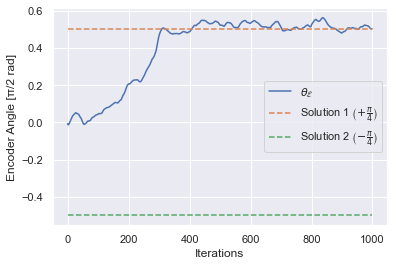

In [22]:
plot_theta(frames, gt_decoder.theta)

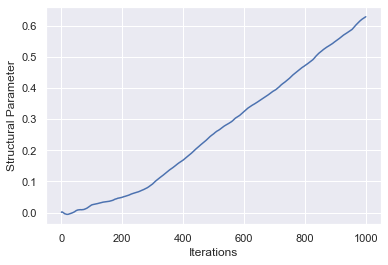

In [23]:
plot_key(frames, 'alpha', name='Structural Parameter')